# Importing Datasets


In [21]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [22]:
# 1. Load datasets
train_df = pd.read_csv('train.csv')  # Load training data
test_df = pd.read_csv('test.csv')  # Load test data

# Initial Data Exploration

In [23]:

print(train_df.head(10))  # Show first few rows


   language  sentence   n                                           edgelist  \
0  Japanese         2  23  [(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...   
1  Japanese         5  18  [(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...   
2  Japanese         8  33  [(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...   
3  Japanese        11  30  [(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...   
4  Japanese        12  19  [(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...   
5  Japanese        14  29  [(23, 29), (18, 23), (28, 18), (28, 12), (28, ...   
6  Japanese        16  19  [(19, 7), (14, 19), (16, 8), (15, 16), (13, 15...   
7  Japanese        21  19  [(9, 10), (14, 9), (18, 14), (7, 8), (16, 7), ...   
8  Japanese        25  19  [(11, 6), (18, 11), (13, 5), (18, 13), (10, 8)...   
9  Japanese        26  23  [(8, 23), (17, 8), (7, 17), (6, 5), (19, 6), (...   

   root  
0    10  
1    10  
2     3  
3    30  
4    11  
5     6  
6    14  
7    18  
8     7  
9     3  


In [24]:
print(train_df.describe())  # Summary statistics


           sentence             n          root
count  10500.000000  10500.000000  10500.000000
mean     494.778000     18.807524      9.844476
std      290.256632      8.190593      7.207740
min        2.000000      3.000000      1.000000
25%      233.500000     13.000000      4.000000
50%      483.000000     18.000000      8.000000
75%      742.250000     23.000000     14.000000
max      995.000000     70.000000     68.000000


In [25]:
print(train_df['language'].value_counts())  # Check language distribution

language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64


In [26]:
train_df.isna().sum()  # Check for missing values

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

# Visualization: Sentence lengths

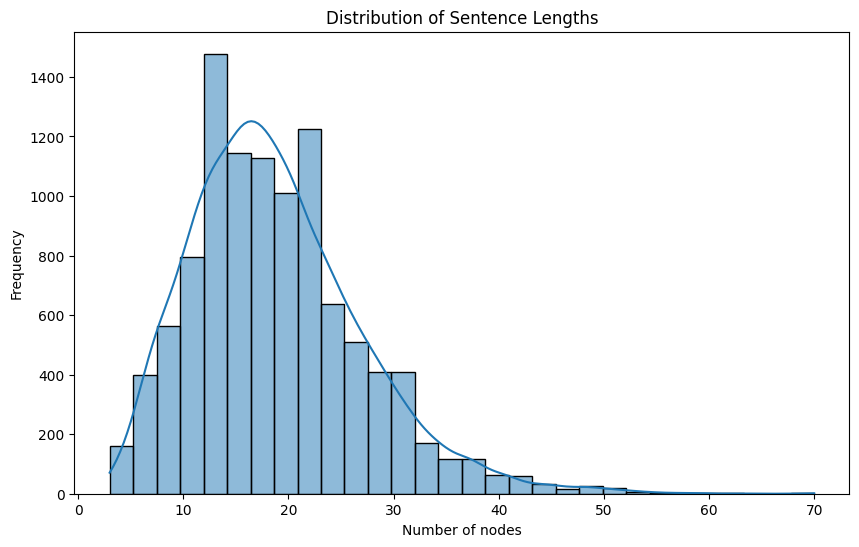

In [ ]:

plt.figure(figsize=(10,6))
sns.histplot(train_df['n'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.show()

# Data preprocessing

In [8]:
# 2. Function to extract centralities
def compute_centralities(edge_list):
    T = nx.from_edgelist(edge_list)
    dc = nx.degree_centrality(T)
    hc = nx.harmonic_centrality(T)
    bc = nx.betweenness_centrality(T)
    pr = nx.pagerank(T)
    try:
        ec = nx.eigenvector_centrality(T)
    except:
        ec = {v: 0 for v in T.nodes()}
    try:
        kc = nx.katz_centrality(T, alpha=0.1)
    except:
        kc = {v: 0 for v in T.nodes()}
    lc = nx.load_centrality(T)
    andc = nx.average_neighbor_degree(T)
    return {v: (dc[v], hc[v], bc[v], pr[v], ec[v], kc[v], lc[v], andc[v]) for v in T}


In [9]:

# 3. Build expanded training data
train_rows = []
for idx, row in train_df.iterrows():
    edges = ast.literal_eval(row['edgelist'])
    T = nx.from_edgelist(edges)
    centralities = compute_centralities(edges)
    root = row['root']
    for node, feats in centralities.items():
        train_rows.append({
            'language': row['language'],
            'sentence': row['sentence'],
            'node': node,
            'n_nodes': row['n'],
            'deg_cent': feats[0],
            'harm_cent': feats[1],
            'betw_cent': feats[2],
            'pagerank': feats[3],
            'eigen_cent': feats[4],
            'katz_cent': feats[5],
            'load_cent': feats[6],
            'avg_neigh_deg': feats[7],
            'target': 1 if node == root else 0
        })

In [10]:
expanded_train = pd.DataFrame(train_rows)
print(expanded_train.head(20))  # Show first few rows of expanded training data

    language  sentence  node  n_nodes  deg_cent  harm_cent  betw_cent  \
0   Japanese         2     6       23  0.090909   5.823846   0.090909   
1   Japanese         2     4       23  0.045455   4.561122   0.000000   
2   Japanese         2     2       23  0.136364   6.991703   0.255411   
3   Japanese         2    23       23  0.045455   5.157179   0.000000   
4   Japanese         2    20       23  0.090909   7.146825   0.311688   
5   Japanese         2    15       23  0.136364   8.038492   0.627706   
6   Japanese         2     3       23  0.090909   5.259535   0.090909   
7   Japanese         2     5       23  0.045455   4.196440   0.000000   
8   Japanese         2    14       23  0.090909   5.865512   0.173160   
9   Japanese         2     8       23  0.090909   6.382179   0.246753   
10  Japanese         2    12       23  0.090909   6.980159   0.311688   
11  Japanese         2     9       23  0.090909   7.317857   0.523810   
12  Japanese         2    18       23  0.090909   7

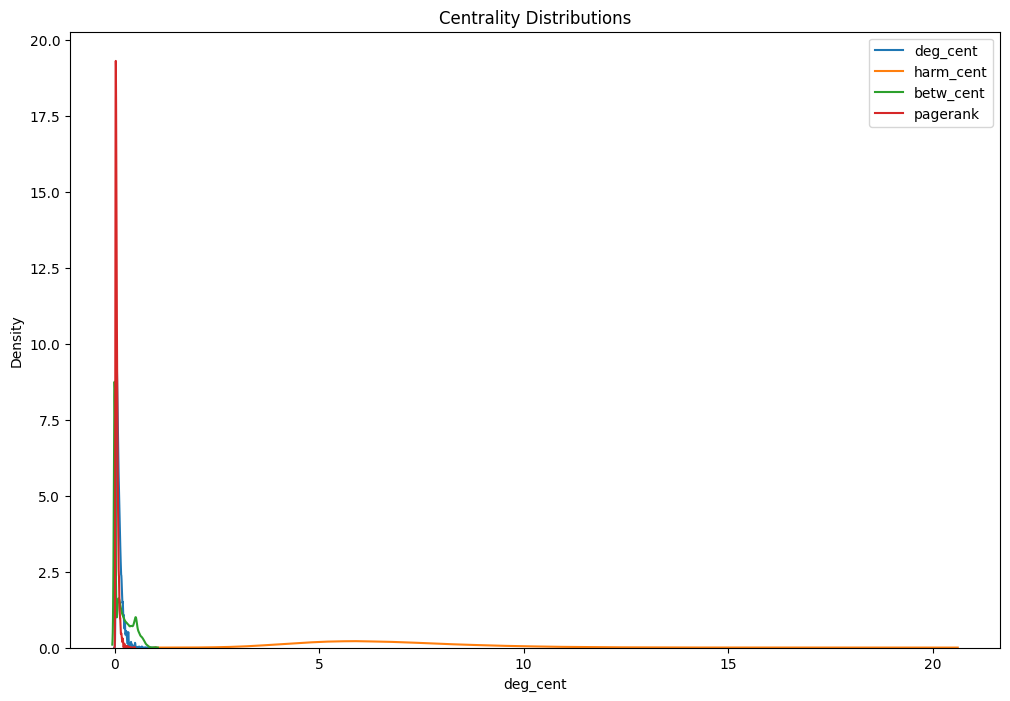

In [11]:

# 4. Analyze Centrality Distributions
plt.figure(figsize=(12,8))
for feature in ['deg_cent', 'harm_cent', 'betw_cent', 'pagerank']:
    sns.kdeplot(expanded_train[feature], label=feature)
plt.title('Centrality Distributions')
plt.legend()
plt.show()

In [12]:
# 5. Normalize centralities **per sentence**
# groupby sentence and language instead?
features = ['deg_cent', 'harm_cent', 'betw_cent', 'pagerank', 'eigen_cent', 'katz_cent', 'load_cent', 'avg_neigh_deg']
expanded_train[features] = expanded_train.groupby('sentence')[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


In [27]:
expanded_train

,language,sentence,node,n_nodes,deg_cent,harm_cent,betw_cent,pagerank,eigen_cent,katz_cent,load_cent,avg_neigh_deg,target
0,Japanese,2,6,23,0.140741,0.300579,0.107955,0.162582,0.000000,0.131346,0.107955,0.130435,0
1,Japanese,2,4,23,0.000000,0.152382,0.000000,0.013913,0.000000,0.001240,0.000000,0.130435,0
2,Japanese,2,2,23,0.281481,0.437642,0.303301,0.289944,0.000000,0.253859,0.303301,0.072464,0
3,Japanese,2,23,23,0.000000,0.222337,0.000000,0.002215,0.000000,0.013491,0.000000,0.304348,0
4,Japanese,2,20,23,0.140741,0.455847,0.370130,0.120814,0.000000,0.158082,0.370130,0.304348,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,Russian,995,19,19,0.077263,0.142225,0.000000,0.113663,0.160012,0.295732,0.000000,0.117647,0
197475,Russian,995,1,19,0.077263,0.247514,0.000000,0.097008,0.335818,0.330517,0.000000,0.558824,0
197476,Russian,995,14,19,0.077263,0.247514,0.000000,0.097008,0.335818,0.330517,0.000000,0.558824,0
197477,Russian,995,5,19,0.247241,0.315704,0.144444,0.286046,0.400077,0.441377,0.144444,0.264706,0


## Imbalance handling

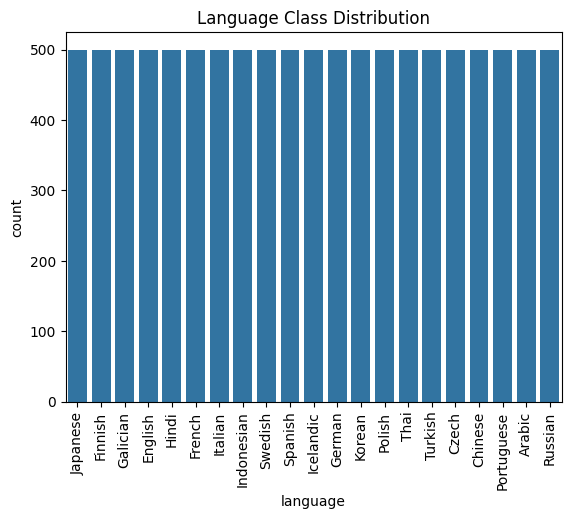

In [13]:
sns.countplot(data=train_df, x='language')
plt.xticks(rotation=90)
plt.title("Language Class Distribution")
plt.show()


In [14]:
import ast
import networkx as nx
from tqdm import tqdm

# Function to remove bottom 25% nodes by degree
def prune_low_degree_nodes(edgelist_str, retain_percent=0.75):
    edges = ast.literal_eval(edgelist_str)
    G = nx.Graph(edges)

    if len(G.nodes) == 0:
        return edges  # nothing to do

    # Sort nodes by degree
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1])
    
    # Keep top N% nodes
    keep_n = int(len(sorted_nodes) * retain_percent)
    keep_nodes = set([node for node, _ in sorted_nodes[-keep_n:]])
    
    # Filter edges
    pruned_edges = [(u, v) for u, v in edges if u in keep_nodes and v in keep_nodes]
    
    return pruned_edges

# Apply pruning only to overrepresented class (e.g., Japanese)
major_class = train_df['language'].value_counts().idxmax()

tqdm.pandas()
train_df['edgelist'] = train_df.progress_apply(
    lambda row: prune_low_degree_nodes(row['edgelist']) if row['language'] == major_class else row['edgelist'],
    axis=1
)


100%|██████████| 10500/10500 [00:00<00:00, 122553.44it/s]


# Modeling


In [15]:
# 6. Modeling setup
X = expanded_train[features + ['n_nodes']]
y = expanded_train['target']
groups = expanded_train['sentence']
X 

,deg_cent,harm_cent,betw_cent,pagerank,eigen_cent,katz_cent,load_cent,avg_neigh_deg,n_nodes
0,0.140741,0.300579,0.107955,0.162582,0.000000,0.131346,0.107955,0.130435,23
1,0.000000,0.152382,0.000000,0.013913,0.000000,0.001240,0.000000,0.130435,23
2,0.281481,0.437642,0.303301,0.289944,0.000000,0.253859,0.303301,0.072464,23
3,0.000000,0.222337,0.000000,0.002215,0.000000,0.013491,0.000000,0.304348,23
4,0.140741,0.455847,0.370130,0.120814,0.000000,0.158082,0.370130,0.304348,23
...,...,...,...,...,...,...,...,...,...
197474,0.077263,0.142225,0.000000,0.113663,0.160012,0.295732,0.000000,0.117647,19
197475,0.077263,0.247514,0.000000,0.097008,0.335818,0.330517,0.000000,0.558824,19
197476,0.077263,0.247514,0.000000,0.097008,0.335818,0.330517,0.000000,0.558824,19
197477,0.247241,0.315704,0.144444,0.286046,0.400077,0.441377,0.144444,0.264706,19


Will the sentences be treated as all sa

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import numpy as np

# Define your param grids
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'model__learning_rate': [0.01, 0.05],
        'model__n_estimators': [100, 300],
        'model__max_depth': [4, 6],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8]
    }
}

# Define your models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model_classes = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=30,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
}

gkf = GroupKFold(n_splits=5)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

print("Cross-validation scores with hyperparameter tuning:")

for name, base_model in model_classes.items():
    pipe = Pipeline([('model', base_model)])
    grid = GridSearchCV(pipe, param_grids[name], cv=gkf, scoring='f1', n_jobs=-1)
    grid.fit(X, y, groups=groups)

    best_model = grid.best_estimator_

    accuracies, precisions, recalls, f1s = [], [], [], []

    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_val)

        accuracies.append(accuracy_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
        recalls.append(recall_score(y_val, y_pred, average='macro', zero_division=0))
        f1s.append(f1_score(y_val, y_pred, average='macro', zero_division=0))

    print(f"\n{name} (best params: {grid.best_params_}):")
    print(f"  Accuracy:  {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}")
    print(f"  Precision: {np.mean(precisions):.4f} +/- {np.std(precisions):.4f}")
    print(f"  Recall:    {np.mean(recalls):.4f} +/- {np.std(recalls):.4f}")
    print(f"  F1 Score:  {np.mean(f1s):.4f} +/- {np.std(f1s):.4f}")


Cross-validation scores with hyperparameter tuning:


/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library


Logistic Regression (best params: {'model__C': 0.01}):
  Accuracy:  0.7571 +/- 0.0043
  Precision: 0.5659 +/- 0.0027
  Recall:    0.7583 +/- 0.0110
  F1 Score:  0.5523 +/- 0.0041


/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest (best params: {'model__max_depth': 20, 'model__n_estimators': 100}):
  Accuracy:  0.9062 +/- 0.0032
  Precision: 0.6004 +/- 0.0082
  Recall:    0.6426 +/- 0.0113
  F1 Score:  0.6163 +/- 0.0093

XGBoost (best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.8}):
  Accuracy:  0.6866 +/- 0.0067
  Precision: 0.5561 +/- 0.0013
  Recall:    0.7526 +/- 0.0061
  F1 Score:  0.5115 +/- 0.0036


In [18]:

# 8. Train final models
for model in models.values():
    model.fit(X, y)


/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sarasaad/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_point

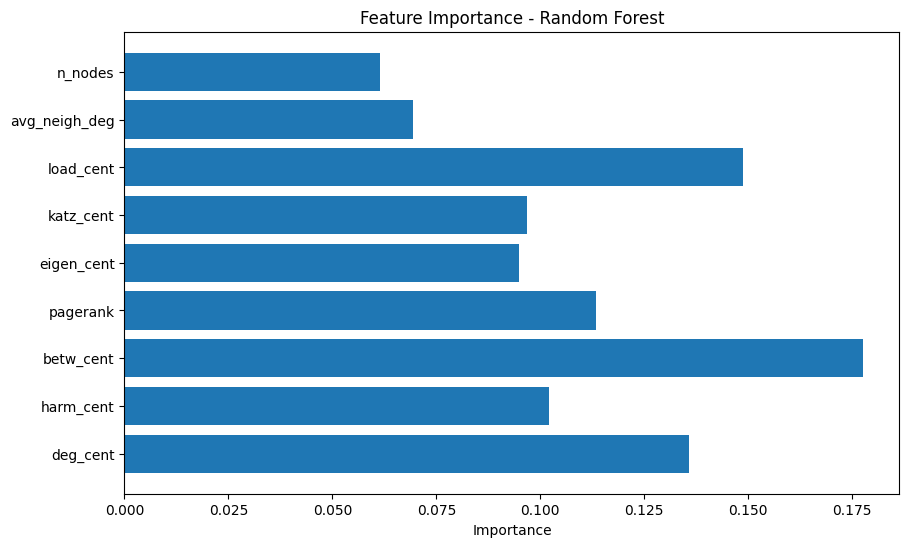

In [19]:
# 9. Feature Importance Analysis (Random Forest Example)
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features + ['n_nodes'], importances)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.show()


In [20]:
# 10. Predicting for the test set
submission_rows = []
for idx, row in test_df.iterrows():
    edges = ast.literal_eval(row['edgelist'])
    T = nx.from_edgelist(edges)
    centralities = compute_centralities(edges)

    test_nodes = []
    test_feats = []
    for node, feats in centralities.items():
        test_nodes.append(node)
        test_feats.append(feats)

    test_feats_df = pd.DataFrame(test_feats, columns=features)

    test_feats_df = pd.DataFrame(MinMaxScaler().fit_transform(test_feats_df), columns=features)

    test_feats_df['n_nodes'] = row['n']

    probs = np.zeros(len(test_feats_df))
    for model in models.values():
        probs += model.predict_proba(test_feats_df)[:, 1]
    probs /= len(models)

    predicted_root = test_nodes[np.argmax(probs)]

    submission_rows.append({
        'id': row['id'],
        'root': predicted_root
    })

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")



Submission file created: submission.csv
